In [129]:
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
import sys
import os
from functools import partial
import jax
from jax import numpy as jnp
import numpy as onp
import math
from lean.distributions import CenteredNormal
from flax.core import FrozenDict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
import os
os.sys.path.append('/Users/yuanqingwang/Documents/GitHub/lean')

In [131]:
def potential(
        x, 
        tao=1.0, 
        a=0.0, 
        b=-4.0, 
        c=0.9, 
        d0=4.0,
        **kwargs,
):
    x = x[..., :, None, :] - x[..., None, :, :]
    x = (x ** 2).sum(-1) + 1e-10
    x = x ** 0.5

    energy = (1 / (2 * tao)) * (
        a * (x - d0)
        + b * (x - d0) ** 2
        + c * (x - d0) ** 4
    )
    return energy

def cos(t):
    return jnp.cos(0.5 * t / math.pi)

def sin(t):
    return jnp.sin(0.5 * t / math.pi)

def coefficient(t, a, b):
    return jax.scipy.special.betainc(a, b, t)

def ess(log_w):
    # normalize
    w = jax.nn.softmax(log_w)
    ess = 1 / (w ** 2).sum()
    return ess

def time_dependent_potential(
        x, 
        tao=1.0, 
        a=0.0, 
        b=-4.0, 
        c=0.9, 
        d0=4.0,
        time=0.0,
        schedule_gaussian=None,
        schedule_a=None,
        schedule_b=None,
        schedule_c=None,
        log_sigma=None,

):
    # gaussian_potential = jax.scipy.stats.norm.logpdf(x, scale=scale).sum(-1).sum(-1).mean()

    gaussian_potential = CenteredNormal(log_sigma).log_prob(x).sum(-1).sum(-1).mean()
    gaussian_potential = (1 - schedule_gaussian(time)) * gaussian_potential

    x = x[..., :, None, :] - x[..., None, :, :]
    x = (x ** 2).sum(-1) + 1e-10
    x = x ** 0.5
    x = x.reshape(*x.shape[:-2], -1)
    a_term = a * (x - d0)
    b_term = b * (x - d0) ** 2
    c_term = c * (x - d0) ** 4

    a_term = a_term * schedule_a(time)
    b_term = b_term * schedule_b(time)
    c_term = c_term * schedule_c(time)
    energy = (1 / (2 * tao)) * (a_term + b_term + c_term).sum(-1).mean()
    energy = energy + gaussian_potential
    return energy

@partial(jax.jit, static_argnums=(1, 3))
def compute_log_w(schedules, sampler_params, key, model):
    schedule_gaussian, schedule_a, schedule_b, schedule_c, nn_params = schedules
    key, key_x, key_v = jax.random.split(key, 3)
    x = CenteredNormal(0.0).sample(key_x, (N_PARTICLES, 2, 1))
    h = jnp.zeros((N_PARTICLES, 2, 1))
    h, v = model.apply(nn_params, h, x)

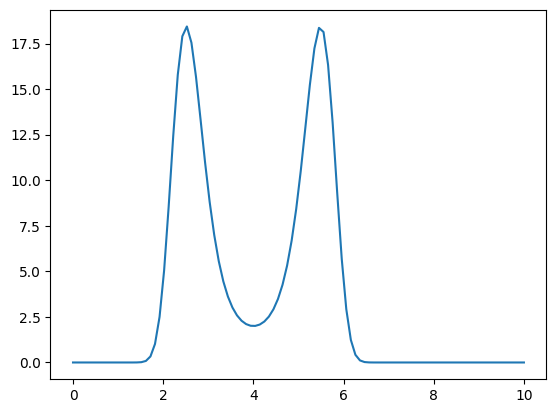

In [132]:
from matplotlib import pyplot as plt
x0 = jnp.linspace(0, 10, 100)
x1 = jnp.zeros_like(x0)
x = jnp.stack([x0, x1], axis=-1)[..., :, None]

plt.plot(
    x0,
    jnp.exp(-potential(x)).sum(-1).sum(-1),
)

In [135]:
position = jax.random.normal(
    jax.random.PRNGKey(0),
    shape=(1000, 2, 1),
)
momentum = jnp.zeros_like(position)
position = position - position.mean(-2, keepdims=True)
momentum = momentum - momentum.mean(-2, keepdims=True)

from lean.schedules import SinRBFSchedule
schedule_gaussian = SinRBFSchedule.init(jax.random.PRNGKey(1), 100)
schedule_a = SinRBFSchedule.init(jax.random.PRNGKey(2), 100)
schedule_b = SinRBFSchedule.init(jax.random.PRNGKey(3), 100)
schedule_c = SinRBFSchedule.init(jax.random.PRNGKey(4), 100)
schedules = [schedule_gaussian, schedule_a, schedule_b, schedule_c]

_time_dependent_potential = partial(
    time_dependent_potential,
    schedule_gaussian=schedule_gaussian,
    schedule_a=schedule_a,
    schedule_b=schedule_b,
    schedule_c=schedule_c,
    log_sigma=0.0,
)

from lean.samplers import LangevinDynamics, HamiltonianMonteCarlo
sampler = LangevinDynamics(_time_dependent_potential, step_size=1e-2, time=10)
position, momentum, deltaS = sampler(position, momentum, key=jax.random.PRNGKey(0))


<Axes: ylabel='Density'>

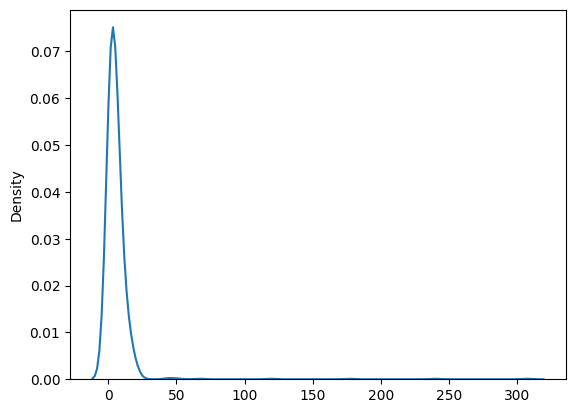

In [136]:
import seaborn as sns
sns.kdeplot(jnp.abs(position[:,0, 0] - position[:,1, 0]))

In [83]:
jnp.abs(position[:,0, 0] - position[:,1, 0]).mean()

Array(2.0440788, dtype=float32)

In [84]:
position

Array([[[ 0.6048788 ],
        [-0.60487866]],

       [[-2.0478845 ],
        [ 2.0478847 ]],

       [[-1.7825423 ],
        [ 1.7825423 ]],

       ...,

       [[-1.41065   ],
        [ 1.4106498 ]],

       [[ 0.47545058],
        [-0.47545046]],

       [[ 2.0175488 ],
        [-2.017549  ]]], dtype=float32)